# LIDA - Automatic Generation of Visualizations and Infographics using Large Language Models

LIDA is a library for generating data visualizations and data-faithful infographics. LIDA is grammar agnostic (will work with any programming language and visualization libraries e.g. matplotlib, seaborn, altair, d3 etc) and works with multiple large language model providers (OpenAI, PaLM, Cohere, Huggingface). Details on the components of LIDA are described in the [paper here](https://arxiv.org/abs/2303.02927) and in this tutorial [notebook](notebooks/tutorial.ipynb). See the project page [here](https://microsoft.github.io/lida/) for updates!.



## Getting Started | Installation

```bash 
pip install lida
```

If you intend to use lida with local huggingface models, you will need to install the `transformers` library. 

```bash
pip install lida[transformers]
```

Dont forget to setup your LLM API key. You can also pass it to the llm object directly. 

```bash
export OPENAI_API_KEY=<your key>
export COHERE_API_KEY=<your key>
# for PaLM
export PALM_SERVICE_ACCOUNT_KEY_FILE=<path to gcp service account key file>
export PALM_PROJECT_ID=<your gcp project id>
```


## The LIDA Python API

Lida offers a manager class that exposes core functionality of the LIDA system. This tutorial will show you how to use the manager class to create visualizations based on a dataset. 


- **Multiple LLM Backends**: LIDA supports multiple LLM backends such as `openai`, `cohere`, `palm`, `huggingface` etc. You can switch between backends by setting the `llm` parameter in the `Manager` class. By default, LIDA uses the `openai` backend. For a list of supported models and how to configure them, see the [llmx documentation](https://github.com/victordibia/llmx).

```python
lida = Manager(text_gen = llm(provider="hf", model="TheBloke/gpt4-x-vicuna-13B-HF", device_map="auto"))
lida = Manager(text_gen = llm("openai")) 
lida = Manager(text_gen = llm("cohere")) 
```
- **Summarization Methods**: The summarizer module works takes an `summary_method` argument which determines if the base summary is enriched by an LLM. By default, the `summary_method` argument is set to `default` for a base summary (statistics etc). Set it to `llm` to enrich/annotate the base summary with an llm. 
- **Caching**: Each manager method takes a [`textgen_config`](https://github.com/victordibia/llmx/blob/7c0fc093d1b8780ebebc7e080f5c63991514038b/llmx/datamodel.py#L22C10-L22C10) argument which is a dictionary that can be used to configure the text generation process (with parameters for model, temperature, max_tokens, topk etc). One of the keys in this dictionary is `use_cache`. If set to `True`, the manager will cache the generated text associated with that method. Use for speedup and to avoid hitting API limits.




In [1]:
# !pip install lida 
# !pip install lida[infographics] # for infographics support

In [2]:
from lida import Manager, TextGenerationConfig , llm  

## Summarize Data, Generate Goals

In [3]:
lida = Manager(text_gen = llm("openai", api_key=None)) # !! api key
textgen_config = TextGenerationConfig(n=1, temperature=0.5, model="gpt-3.5-turbo-0301", use_cache=True)

summary = lida.summarize("https://raw.githubusercontent.com/uwdata/draco/master/data/cars.csv", summary_method="default", textgen_config=textgen_config)  
goals = lida.goals(summary, n=2, textgen_config=textgen_config)

for goal in goals:
    display(goal)


### Goal 0

**Question:** What is the distribution of Retail_Price?

**Visualization:** `histogram of Retail_Price`

**Rationale:** This tells about the spread of prices of cars in the dataset.



### Goal 1

**Question:** How do the Horsepower_HP_ and City_Miles_Per_Gallon correlate?

**Visualization:** `scatter plot of Horsepower_HP_ vs City_Miles_Per_Gallon`

**Rationale:** This helps to understand if there is a relationship between the engine power and fuel efficiency of the cars.


## Generate Visualizations

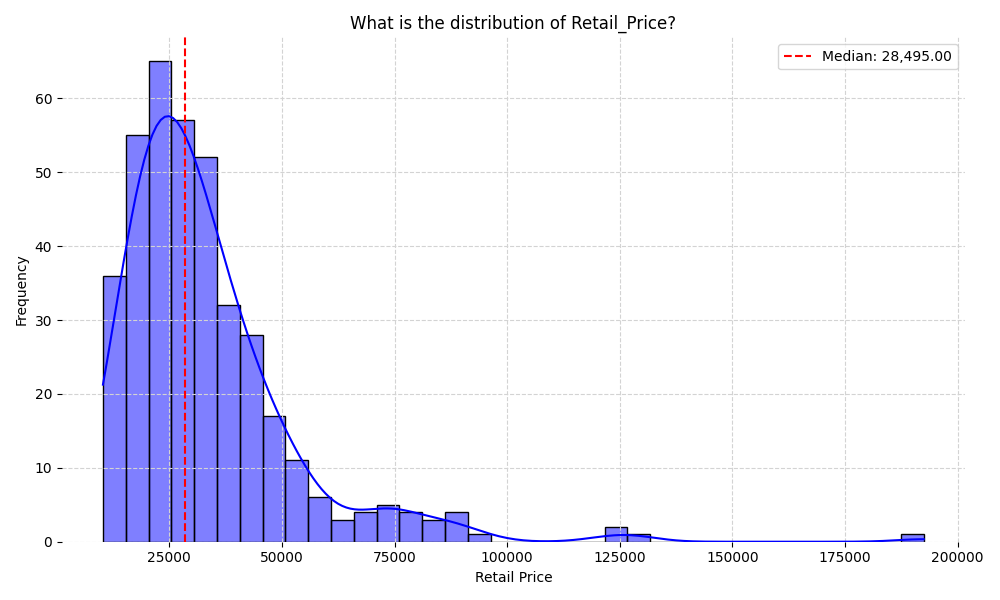

In [4]:
i = 0
library = "seaborn"
textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=goals[i], textgen_config=textgen_config, library=library)  
charts[0]

# VizOps

Given that LIDA represents visualizations as code,
the VISGENERATOR also implements submodules
to perform operations on this representation. 

This includes 
- **Natural language based visualization refinement**: Provides a conversational api to iteratively
4Execution in a sandbox environment is recommended.
refine generated code (e.g., translate chart t hindi
. . . zoom in by 50% etc) which can then be executed to generate new visualizations.
- **Visualization explanations and accessibility**:
Generates natural language explanations (valuable
for debugging and sensemaking) as well as accessibility descriptions (valuable for supporting users
with visual impairments).

- **Visualization code self-evaluation and repair**:
Applies an LLM to self-evaluate generated code on
multiple dimensions (see section 4.1.2).

- **Visualization recommendation**: Given some context (goals, or an existing visualization), recommend additional visualizations to the user (e.g., for
comparison, or to provide additional perspectives).



## Natural language based visualization refinement 

Given some code, modify it based on natural language instructions. This yields a new code snippet that can be executed to generate a new visualization.

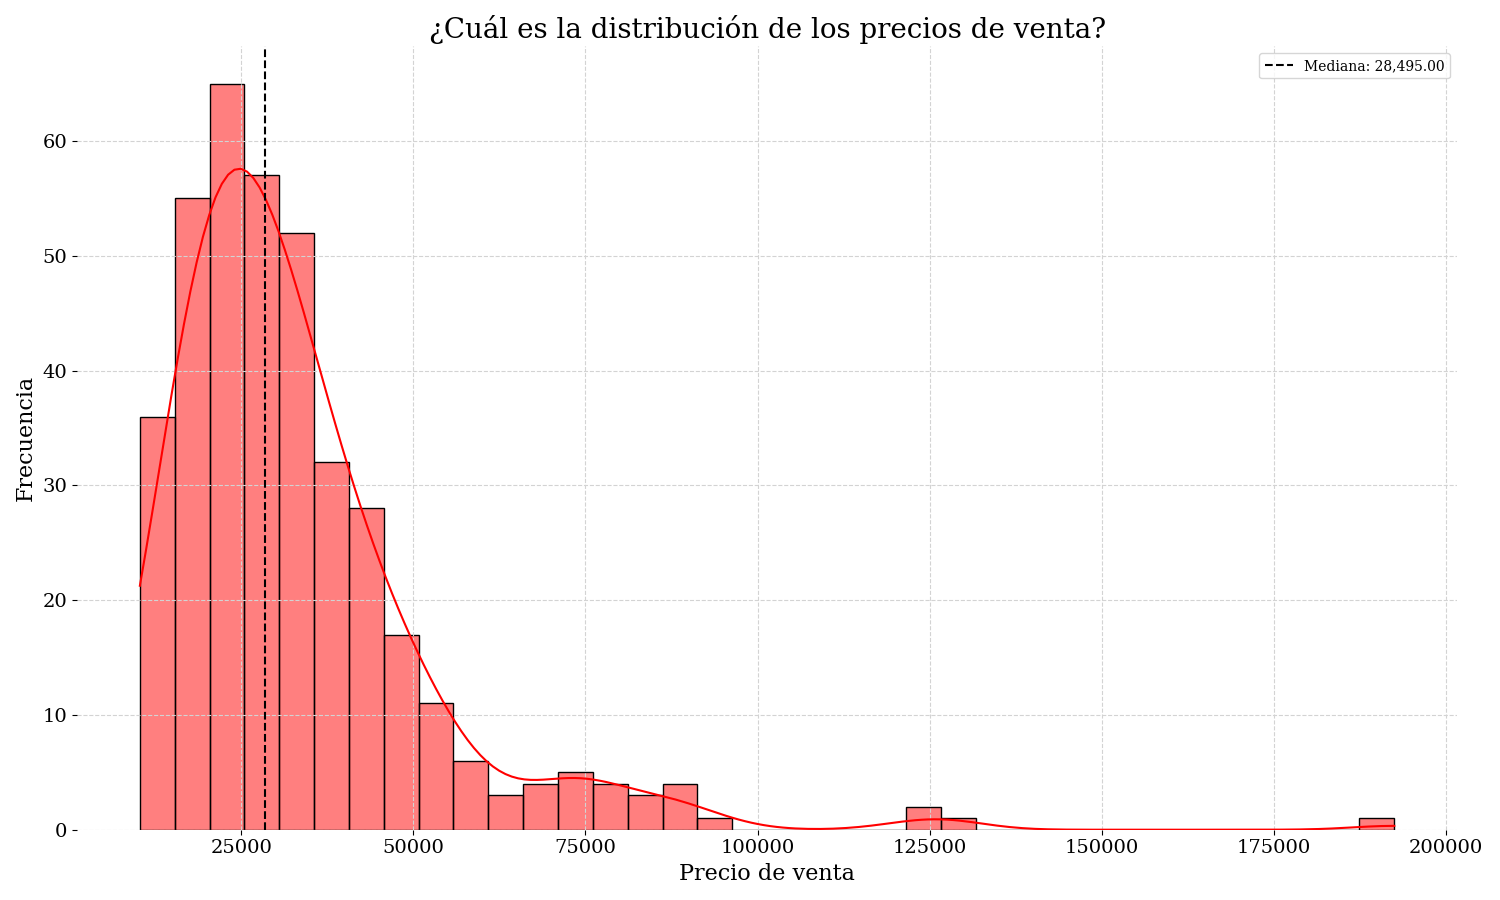

In [5]:
code = charts[0].code
textgen_config = TextGenerationConfig(n=1, temperature=0, use_cache=True)
instructions = ["zoom in 50%", "make the chart height and width equal", "change the color of the chart to red", "translate the chart to spanish"]
edited_charts = lida.edit(code=code,  summary=summary, instructions=instructions, library=library, textgen_config=textgen_config)
edited_charts[0]

## Visualization explanations and accessibility

In [6]:
explanations = lida.explain(code=code, library=library, textgen_config=textgen_config) 
for row in explanations[0]:
    print(row["section"]," ** ", row["explanation"])

accessibility  **  The chart is a histogram with a blue color and a transparency of 0.5. The chart also has a red vertical line indicating the median value of the Retail_Price column. The chart's goal is to show the distribution of the Retail_Price column in the provided data. The main insight from the chart is the shape of the distribution and the location of the median value.
transformation  **  There is no data transformation in this code.
visualization  **  The code starts by creating a figure with a size of 10 by 6 inches. Then, it uses the seaborn library to create a histogram of the Retail_Price column in the provided data. The histogram has a blue color and a transparency of 0.5. The kde parameter is set to True to show the kernel density estimation of the distribution. The code then adds a vertical red line at the median value of the Retail_Price column using the axvline method. The linestyle is set to '--' to make the line dashed. The label parameter is used to add a legend t

## Visualization code self-evaluation and repair

In [7]:
evaluations = lida.evaluate(code=code,  goal=goals[i], library=library)[0] 
for eval in evaluations:
    print(eval["dimension"], "Score" ,eval["score"], "/ 10")
    print("\t", eval["rationale"][:200])
    print("\t**********************************")

bugs Score 10 / 10
	 The code is free of bugs, syntax errors, or typos.
	**********************************
transformation Score 10 / 10
	 The data is appropriately filtered and no additional transformation is needed for the histogram.
	**********************************
compliance Score 10 / 10
	 The code meets the specified visualization goal of showing the distribution of Retail_Price.
	**********************************
type Score 9 / 10
	 The histogram is an appropriate visualization type for showing the distribution of a single variable. However, a boxplot or violin plot could also be used to show the distribution and provide addition
	**********************************
encoding Score 10 / 10
	 The data is encoded appropriately with Retail_Price on the x-axis.
	**********************************
aesthetics Score 10 / 10
	 The aesthetics of the visualization are appropriate for a histogram, with a blue color and alpha of 0.5 for the bars, a red dashed line for the median, and a cl

## Visualization Recommendation

In [8]:
import json 

dstring = """['import seaborn as sns\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\ndef plot(data: pd.DataFrame):\n    # solution code\n    plt.figure(figsize=(10, 6))\n    sns.scatterplot(data=data, x="Retail_Price", y="Horsepower_HP_", hue="Type", style="AWD")\n    plt.title("What is the relationship between Retail_Price, Horsepower_HP_ and Type?", wrap=True)\n    plt.xlabel("Retail Price")\n    plt.ylabel("Horsepower_HP_")\n    plt.tight_layout()\n    return plt\n\nchart = plot(data)']"""
# d0 = json.loads(dstring)

In [9]:
textgen_config = TextGenerationConfig(n=1, temperature=0, use_cache=True)
recommended_charts =  lida.recommend(code=code, summary=summary, n=2,  textgen_config=textgen_config)

Recommended 2 charts


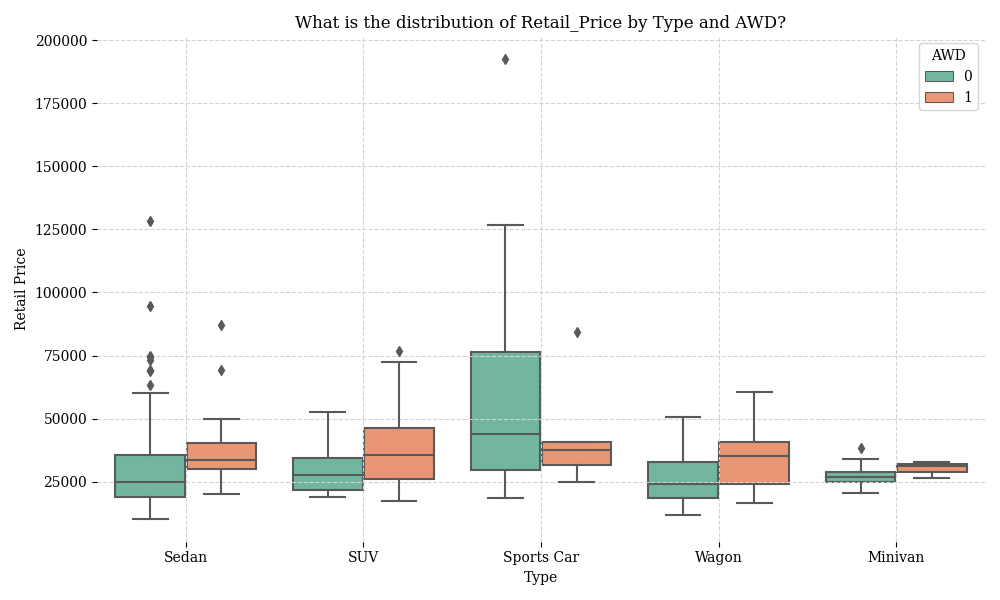

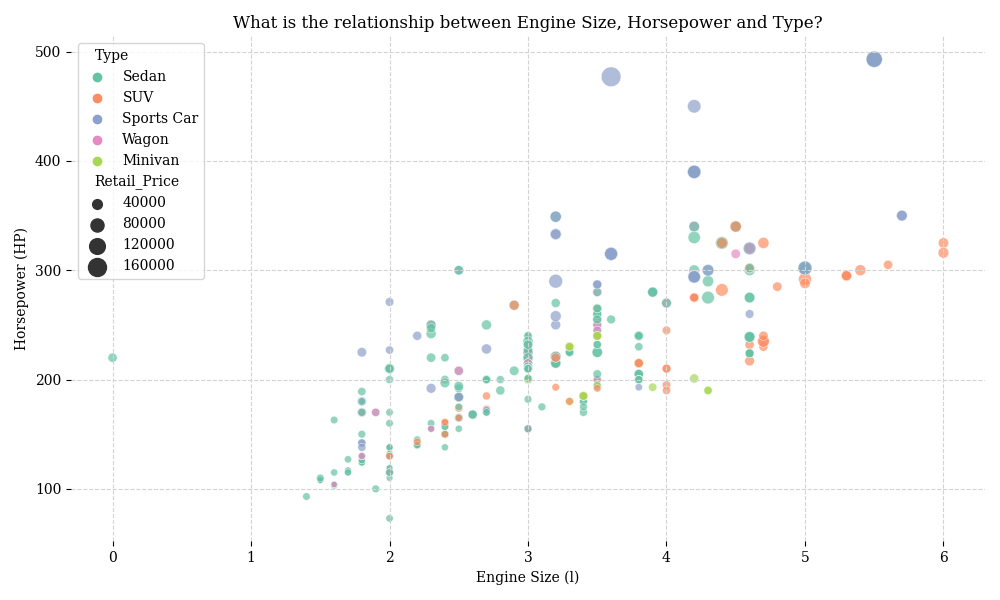

In [10]:
print(f"Recommended {len(recommended_charts)} charts")
for chart in recommended_charts:
    display(chart) 

## Infographics (Beta)

- Explores using LIDA to generate infographics from an existing visualization 
- Uses the `peacasso` package, and loads open source stable diffusion models 
- You will need to run `pip install lida[infographics]` to install the required dependencies.
- Currently work in progress (work being done to post process infographics with chart axis and title overlays from the original visualization, add presets for different infographic styles, and add more stable diffusion models)


In [11]:
# !pip install lida[infographics] 
# ensure you have a GPU runtime

In [12]:
infographics = lida.infographics(visualization = edited_charts[0].raster, n=1, style_prompt="pastel art, rain drops, highly detailed, no blur, white background")

/home/victordibia/miniconda3/envs/coral/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 29 files:  55%|█████▌    | 16/29 [00:00<00:00, 38.25it/s]



















































































Fetching 29 files: 100%|██████████| 29/29 [00:10<00:00,  2.64it/s]
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Resizing init_image to (512, 512).
100%|██████████| 31/31 [00:01<00:00, 16.68it/s]


In [13]:
plot_raster([edited_charts[0].raster, infographics["images"][0]]) 

NameError: name 'plot_raster' is not defined